# Timo Blattner 19-115-351

In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms.functional as TF
from scipy.stats import norm
from torch.autograd import Variable
import matplotlib.pyplot as plt
import PIL.Image as Image
import pandas as pd
import random
import sys
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


The UnsupervisedDataset class will load and prepare the data for the unsupervised learning part. The idea is to randomly rotate the images by [0, 90, 180, 270] degrees and add the corresponding label. The model has to predict the rotation, by doing that is will hopefully learn the best feature representation.

In [3]:
class UnsupervisedDataset(Dataset):
    def __init__(self, folder_path, phase='train', transform=None):
        super(UnsupervisedDataset, self).__init__()

        self.transform = transform

        self.phase = phase
        if self.phase == 'train':
            file_path = os.path.join(folder_path, 'train_32x32_unlabel.npy')
        elif self.phase == 'valid':
            file_path = os.path.join(folder_path, 'test_32x32_competition.npy')
        else:
            print('Unrecognized phase!')

        data_load = np.load(file_path)
        self.dataset = data_load

    def __getitem__(self, index): 
        image = Image.fromarray(self.dataset[index,:])

        r = random.choice([0, 1, 2, 3])
        img_index = image.rotate(r*90)
        
        return self.transform(img_index), r

    def __len__(self):
        return self.dataset.shape[0]

In [4]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.0, 1.0)])

unsupervised_train_set = UnsupervisedDataset('/content/drive/MyDrive/Colab Notebooks/Assignement3/atml-assignment-3-data/', phase='train', transform=transform)
unsupervised_valid_set = UnsupervisedDataset('/content/drive/MyDrive/Colab Notebooks/Assignement3/atml-assignment-3-data/', phase='valid', transform=transform)

unsupervised_train_loader = DataLoader(unsupervised_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
unsupervised_valid_loader = DataLoader(unsupervised_valid_set, batch_size=batch_size, shuffle=True, num_workers=2)

print("Unsupervised training set size: " + str(len(unsupervised_train_set)))
print("Unsupervised validation set size: " + str(len(unsupervised_valid_set)))

Unsupervised training set size: 72257
Unsupervised validation set size: 24032


The SupervisedDataset class will load the data for the supervised learning part. The task is to classify the images into the 10 digit categories.


In [5]:
class SupervisedDataset(Dataset):
    def __init__(self, folder_path, phase='train', transform=None):
        super(SupervisedDataset, self).__init__()

        self.phase = phase
        if self.phase == 'train':
            file_path = os.path.join(folder_path, 'train_32x32_500_label.npz')
        elif self.phase == 'valid':
            file_path = os.path.join(folder_path, 'test_32x32_2000_label.npz')
        elif self.phase == 'test':
            file_path = os.path.join(folder_path, 'test_32x32_competition.npy')
        else:
            print('Unrecognized phase')

        data_load = np.load(file_path)
        if self.phase != 'test':
            self.dataset = data_load['img']
            self.labels = data_load['label'].astype('int64')
        else:
            self.dataset = data_load
        
        self.transform = transform
        
    def __getitem__(self, index): 
        image = Image.fromarray(self.dataset[index,:])

        if self.phase != 'test':
            return self.transform(image), self.labels[index, 0]
        else:
            return self.transform(image)

    def __len__(self):
        return self.dataset.shape[0]

In [6]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.0, 1.0)])

supervised_train_set = SupervisedDataset('/content/drive/MyDrive/Colab Notebooks/Assignement3/atml-assignment-3-data/', phase='train', transform=transform)
supervised_valid_set = SupervisedDataset('/content/drive/MyDrive/Colab Notebooks/Assignement3/atml-assignment-3-data/', phase='valid', transform=transform)
supervised_test_set = SupervisedDataset('/content/drive/MyDrive/Colab Notebooks/Assignement3/atml-assignment-3-data/', phase='test', transform=transform)

supervised_train_loader = DataLoader(supervised_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
supervised_valid_loader = DataLoader(supervised_valid_set, batch_size=batch_size, shuffle=True, num_workers=2)
supervised_test_loader = DataLoader(supervised_test_set, batch_size=batch_size, num_workers=2)

print("Supervised training set size: " + str(len(supervised_train_set)))
print("Supervised validation set size: " + str(len(supervised_valid_set)))
print("Supervised testing set size: " + str(len(supervised_test_set)))

Supervised training set size: 500
Supervised validation set size: 2000
Supervised testing set size: 24032


Let's look at some examples

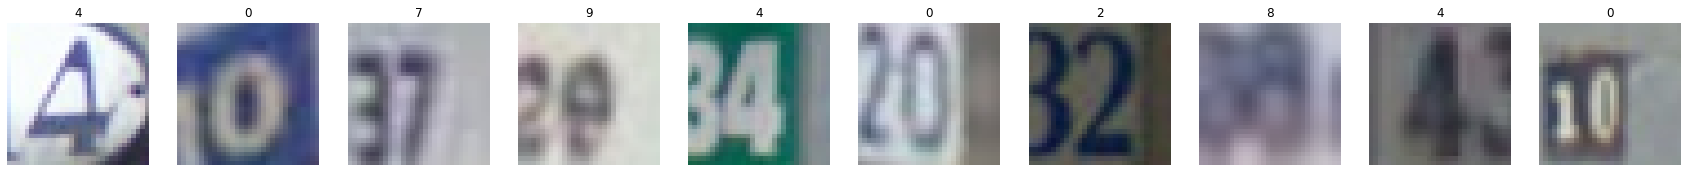

In [7]:
def show_examples(dataset, n=10):
  fig, axs = plt.subplots(1, n, figsize=(30, 5))
  
  for i in range(n):
    index = random.randrange(len(dataset))
    (sample_image, sample_label) = dataset[index]
    img = np.transpose(sample_image, (1, 2, 0))
    axs[i].imshow(img)
    axs[i].set_title(str(sample_label))
    axs[i].axis('off')

show_examples(supervised_train_set)

We see that some examples are really unsharp, rotated or contain multiple digits. So it will be challenging for the model to learn, especially because we only have 500 examples for the supervised learning.

# Initializing the model



After having tried with two models and different configurations, I decided to use a single CNN which can switch between the two task. The idea is to let the model learn on the unsupervised part, and then onto the supervised part. But the model will keep the first two layer groups of the unsupervised part, with modified learning rates.



In [8]:
class Transfer_CNN(nn.Module):
    def __init__(self, supervised=False):
        super(Transfer_CNN, self).__init__()
        self.supervised = supervised
        self.init_unsupervised()
        self.init_supervised()

    def init_unsupervised(self):
        self.unsup1 = nn.Sequential(
            nn.Conv2d(in_channels=3, kernel_size=3, padding=1, out_channels=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, kernel_size=3, padding=1, out_channels=32),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        self.unsup2 = nn.Sequential(
            nn.Conv2d(in_channels=32, kernel_size=3, padding=1, out_channels=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, kernel_size=3, padding=1, out_channels=64),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        self.unsup3 = nn.Sequential(
            nn.Conv2d(in_channels=64, kernel_size=3, out_channels=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.unsup4 = nn.Sequential(
            nn.Linear(in_features=128*9, out_features=4),
            nn.Sigmoid()
        )


    def init_supervised(self):
        self.sup1 = nn.Sequential(
            nn.Conv2d(in_channels=64, kernel_size=3, out_channels=128),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        self.sup2 = nn.Sequential(
            nn.Conv2d(in_channels=128, kernel_size=3, out_channels=256),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        self.sup3 = nn.Sequential(
            nn.Linear(in_features=256*9, out_features=100),
            nn.ReLU()
        )
        self.sup4 = nn.Sequential(
            nn.Linear(in_features=100, out_features=10),
            nn.Sigmoid()
        )

        
    def forward(self, x):
        if self.supervised:
            #supervised learning
            x = self.unsup1(x)
            x = self.unsup2(x)
            x = self.sup1(x)
            x = self.sup2(x)
            x = x.view(-1, 256*9)
            x = self.sup3(x)
            x = self.sup4(x)
        else:
            #unsupervised learning
            x = self.unsup1(x)
            x = self.unsup2(x)
            x = self.unsup3(x)
            x = x.view(-1, 128*9)
            x = self.unsup4(x)
        return x


model = Transfer_CNN(supervised=False)
model.to(device)
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.loss_function = nn.CrossEntropyLoss()

The accuracy is simply the sum of correct prediction divided by every prediction.

In [9]:
def get_accuracy(labels, predictions):
    accuracy = (predictions == labels).sum().item() / len(labels)
    return accuracy

This is the code for evaluation of the model.

In [10]:
def evaluate_model(model, dataloader):
    model.eval()
    count = 0
    accuracy = 0
    losses = 0

    with torch.no_grad():
        for i, input in enumerate(dataloader):
          #inputs = (images, labels)
          images = input[0].to(device)
          labels = input[1].to(device)

          #get prediction
          predictions = model(images)

          #accuracy
          predicted_labels = predictions.argmax(dim=1)
          accuracy += get_accuracy(labels, predicted_labels)

          #loss
          loss = model.loss_function(predictions, labels)
          losses += loss.item()

          count += 1

    #average out
    accuracy = 100 * (accuracy / count)
    avg_loss = losses / count

    return avg_loss, accuracy

The training code for the model.

In [11]:
def train_model(model, dataloader):
    model.train()
    accuracy = 0
    losses = 0
    count = 0

    for i, input in enumerate(dataloader):
        #inputs = (images, labels)
        images = input[0].to(device)
        labels = input[1].to(device)

        #get prediction
        predictions = model(images)

        #accuracy
        predicted_labels = predictions.argmax(dim=1)
        accuracy += get_accuracy(labels, predicted_labels)

        #loss
        loss = model.loss_function(predictions, labels)
        losses += loss.item()

        #backpropagation
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()

        if i % 100 == 0:
          print("   - " + str(i))
        count += 1


    #average out
    avg_loss = losses / float(count)
    accuracy = 100 * (accuracy / count)

    return avg_loss, accuracy

And the run function which switches between training the model and evaluating the model, with a given number of epochs.

In [12]:
def run(model, train_loader, valid_loader, num_epochs=10):
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    print("\n__Start__\n")
    t0 = time.time()

    for epoch in range(num_epochs):
        print("Epoch " + str(epoch))

        #training
        print(" * training")
        training_loss, training_accuracy = train_model(model, train_loader)

        #validation
        print(" * validating")
        validation_loss, validation_accuracy = evaluate_model(model, valid_loader)

        #lists
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

    print("\n__Finished__\n")
    print("Runtime: " + str(int(time.time() - t0)) + "s")

    return training_losses, training_accuracies, validation_losses, validation_accuracies

# Unsupervised Learning

So we can now train the model on the unsupervised, rotated dataset. And the unsupervised validation set will be used to track overfitting.

In [ ]:
training_losses, training_accuracies, validation_losses, validation_accuracies = run(model, unsupervised_train_loader, unsupervised_valid_loader, 20)

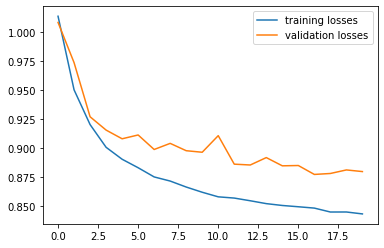

In [14]:
plt.plot(training_losses, label="training losses")
plt.plot(validation_losses, label="validation losses")
plt.legend()

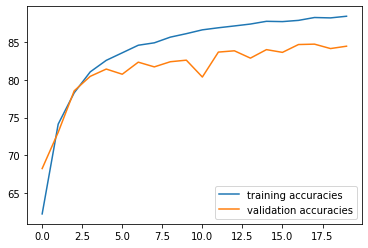

In [15]:
plt.plot(training_accuracies, label="training accuracies")
plt.plot(validation_accuracies, label="validation accuracies")
plt.legend()

Over 80% is pretty good considering the dataset, but we must be careful about overfitting. Let's look at some predictions, selected randomly (the numbers above show the predicted category, and the correct category).

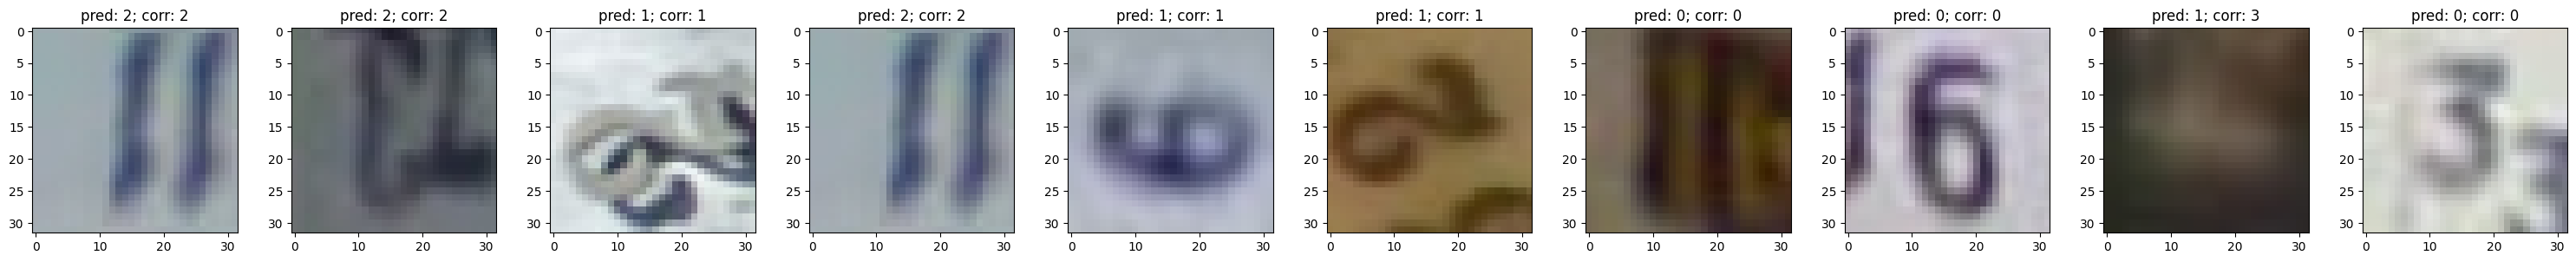

In [16]:
def visualize_model_predictions(model, dataloader, n=10):
    plt.style.use("default")
    fig, axs = plt.subplots(1, n, figsize=(30, 3))
    fig.tight_layout()

    images, labels = iter(dataloader).next()
    input = images.to(device)

    predictions = model(input)
    predicted_labels = predictions.argmax(dim=1)

    for i in range(n):
        index = random.randrange(len(labels))

        img = images[index]
        predicted_label = predicted_labels[index]
        correct_label = labels[index]

        axs[i].set_title("pred: " + str(predicted_label.item()) + "; corr: " + str(correct_label.item()))
        axs[i].imshow(np.transpose(img, (1, 2, 0)))

model.supervised = False
visualize_model_predictions(model, unsupervised_valid_loader)

We see that the model does a pretty good job. Sometimes it would be even complicated for a human to correctly predict the rotation, because of the unsharpness of the images and missing context.

So it might be a good time to save the model, because the training is pretty long, so  we can use it later.

In [17]:
#saving our model
path = F"/content/drive/MyDrive/Colab Notebooks/Assignement3/model.pt" 
torch.save(model.state_dict(), path)

# Supervised Learning

So now we will make use of the learned feature extrator.

## First Baseline

In [18]:
#load our model
path = F"/content/drive/MyDrive/Colab Notebooks/Assignement3/model.pt"
model1 = Transfer_CNN(supervised=True)
model1.to(device)
model1.load_state_dict(torch.load(path))

<All keys matched successfully>

So we will use the finetuned features method. The idea is to use two of the layer groups of the unsupervised part, but giving the smaller learning rates. The hypthosis is that the model can slighty adapt these layers, but not unlearn what it learned on the unsupervised task. 

In [19]:
unsup1_params = list(map(id, model1.unsup1.parameters()))
unsup2_params = list(map(id, model1.unsup2.parameters()))
base_params = filter(lambda p: id(p) not in unsup1_params + unsup2_params, model1.parameters())

params = [{'params': model1.unsup1.parameters(), 'lr': 0.00001},
          {'params': model1.unsup2.parameters(), 'lr': 0.001},
          {'params': base_params, 'lr': 0.001},]

model1.optimizer = torch.optim.Adam(params)
model1.loss_function = nn.CrossEntropyLoss()

So basically the first layer group has only the hundredth of the ability to change, and the second layer group only the tenth compared to the rest of the network.

In [ ]:
training_losses, training_accuracies, validation_losses, validation_accuracies = run(model1, supervised_train_loader, supervised_valid_loader, 10)

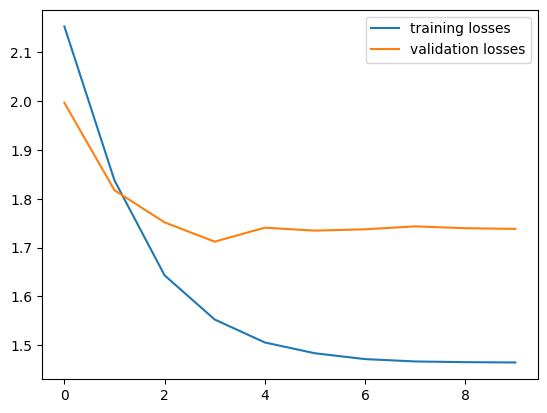

In [21]:
plt.plot(training_losses, label="training losses")
plt.plot(validation_losses, label="validation losses")
plt.legend()

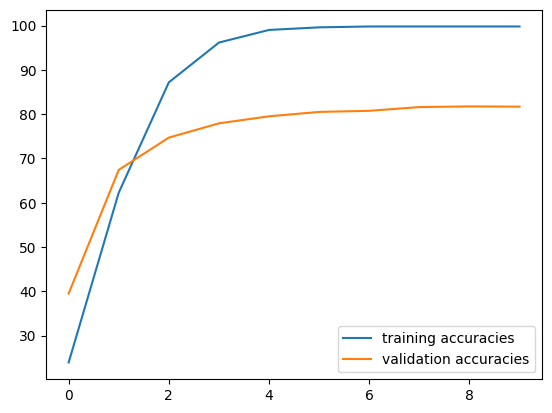

In [22]:
plt.plot(training_accuracies, label="training accuracies")
plt.plot(validation_accuracies, label="validation accuracies")
plt.legend()

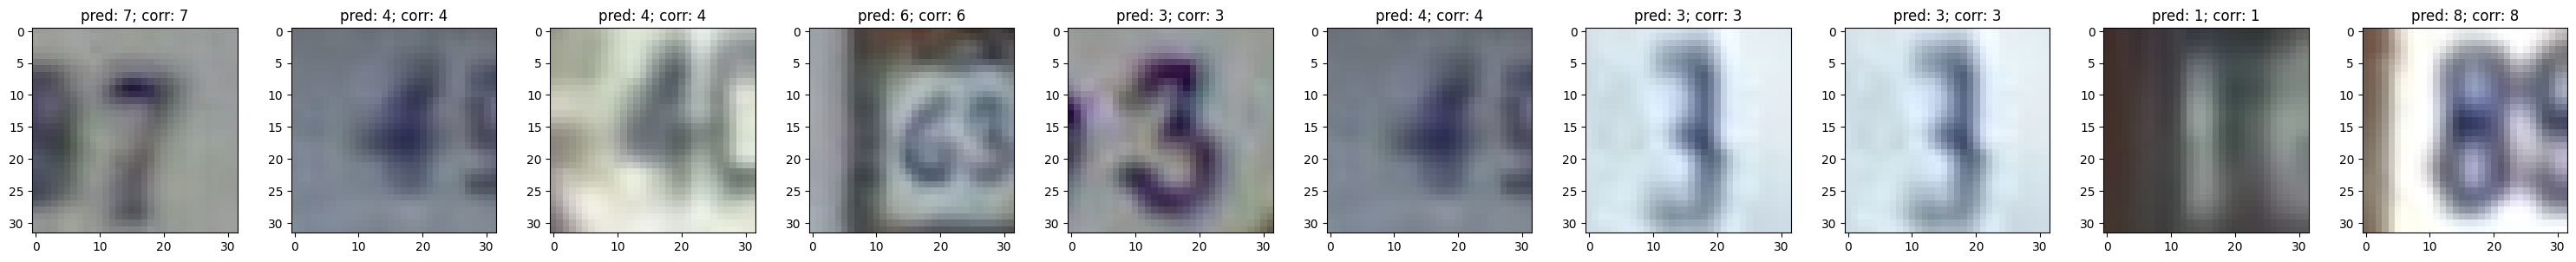

In [23]:
visualize_model_predictions(model1, supervised_valid_loader)

The more noise, the harder for the model to predict the correct digit. Sometimes multiple numbers on the image can also trouble the model.

## Second Baseline

In [24]:
#load our model
path = F"/content/drive/MyDrive/Colab Notebooks/Assignement3/model.pt"
model2 = Transfer_CNN(supervised=True)
model2.to(device)
model2.load_state_dict(torch.load(path))

<All keys matched successfully>

We do basically the same as for the first baseline, but we are setting the learning rate of the first two layer groups to zero, so they can't be changed. Thus we have a fixed feature extractor.

In [25]:
model2.supervised = True #switch mode

unsup1_params = list(map(id, model2.unsup1.parameters()))
unsup2_params = list(map(id, model2.unsup2.parameters()))
base_params = filter(lambda p: id(p) not in unsup1_params + unsup2_params, model2.parameters())

params = [{'params': model2.unsup1.parameters(), 'lr': 0.0},
          {'params': model2.unsup2.parameters(), 'lr': 0.0},
          {'params': base_params, 'lr': 0.001},]

model2.optimizer = torch.optim.Adam(params)
model2.loss_function = nn.CrossEntropyLoss()

In [ ]:
training_losses, training_accuracies, validation_losses, validation_accuracies = run(model2, supervised_train_loader, supervised_valid_loader, 10)

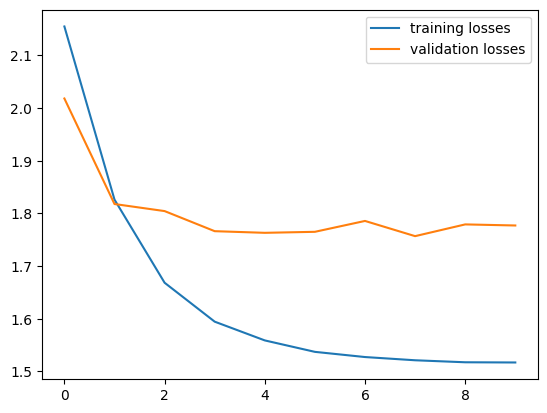

In [27]:
plt.plot(training_losses, label="training losses")
plt.plot(validation_losses, label="validation losses")
plt.legend()

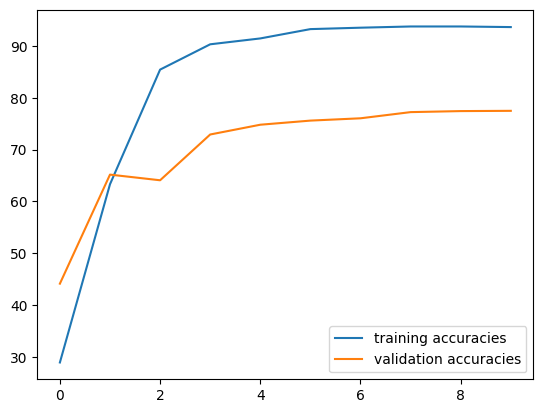

In [28]:
plt.plot(training_accuracies, label="training accuracies")
plt.plot(validation_accuracies, label="validation accuracies")
plt.legend()

# Report

First of all, we can see a lot of overfitting in both models. The reason being that we just have to few examples, only 500! The model is way too complex for this small dataset size. But overfitting on the training set doesn't seem to be incompatible we decent validation accuracy. In my tests using regularization methods like weight decay and dropout actually deacreased the models performance overall. Interestingly, finetuned and fixed features actually don't influence the models performance much. It can be that the model has already learned an excellent feature representation in the unsupervised learning part. But where does it fail? Let's look at the confusion matrix.

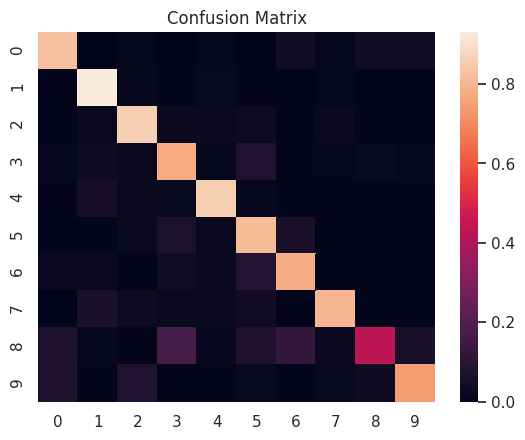

In [29]:
import seaborn as sns; sns.set_theme()

def confusion_matrix(model, dataloader):
    model.eval()

    #count the number of occurence
    count = np.zeros((10, 10))
    
    with torch.no_grad():
        for i, input in enumerate(dataloader):
            #inputs = (images, labels)
            images = input[0].to(device)
            labels = input[1].to(device)

            #get prediction
            predictions = model(images)
            predicted_labels = predictions.argmax(dim=1)
    
            #count
            for j in range(len(labels)):
                y = labels[j]
                x = predicted_labels[j]
                count[y][x] += 1

    #normalize between lines
    for y in range(10):
        count[y] /= sum(count[y])

    ax = sns.heatmap(count)
    ax.set_title('Confusion Matrix')

confusion_matrix(model1, supervised_valid_loader)

I scaled each line, so we can have the accuracy in pourcentage. The 8 seems the one causing the trouble, let's look at the representation of the numbers in training set.

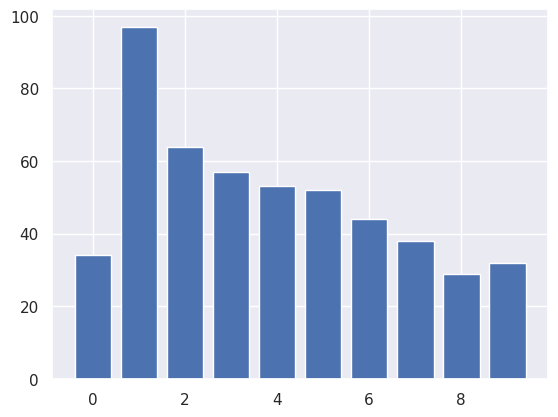

In [30]:
def show_label_distribution(dataset):
    label = [i for i in range(10)]
    count = [0] * 10
    for i in range(len(dataset)):
        count[dataset[i][1]] += 1
    
    plt.bar(label, count)

show_label_distribution(supervised_train_set)

So it goes again to show, how important the distribution in the dataset is! One is overrepresented and has the best accuracy, nine the least and the worst accuracy. This effect is amplified by the overfitting of the model. On the other hand, zero seems to perform quite well even with the underrepresentation. My hypthosis is that it has a pretty unique shape compared to the other digits, and thus the feature extractor can pick up the pattern easily. I tried to fix this problem by using a different loss function, the multi-margin-loss. The hypthosis was that by using margins the model could cluster the numbers in different categories very easily. But it didn't improve, and I still can't get to my targeted 80% after a lot of tries...

**Conclusion:** the designing of a model for such a task is quite tricky. I ended up taking a proven model architecture on digit classification and adapting to my needs. What worked the best was using the first two layer groups, which seemed to have learned the feature pretty nicely. The back of the model was adapted to the different needs of the classification. Sometimes this iterating process is very frustrating, when you don't see better results. But overall it was a very interesting project(s) where I learned a lot. It's a fascinating field, and I am glad I took the course.

# Upload

In [31]:
def get_predictions(model, dataloader):
    predictions = []

    with torch.no_grad():
        for input in dataloader:
            images = input.to(device)

            predicted = model(images).cpu()
            predicted_labels = predicted.argmax(dim=1).cpu().detach().numpy()

            predictions.extend(predicted_labels)

            images = input.to(device)
            outputs = model(images).cpu()

    return np.array(predictions)

predictions = get_predictions(model1, supervised_test_loader)

In [32]:
predictions = pd.DataFrame({
    "Id": np.arange(predictions.size),
    "Category": predictions},
    dtype=np.int64)

In [33]:
predictions.to_csv("timo_blattner_predictions.csv", index=False)